In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixtureModel(BaseModel):
    NAME = "mixture_model"

    def __init__(self, config: Config):
        super(MixtureModel, self).__init__(config=config)
        self.combination_columns = [self.subject] + self.features

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(5))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(5))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(.5))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(10))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(5))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(5))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                a_mean = numpyro.sample("a_mean", dist.TruncatedNormal(50., 20., low=0))
                a_scale = numpyro.sample("a_scale", dist.HalfNormal(30.))

                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("ell_scale", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.sample(
                        site.a, dist.TruncatedNormal(a_mean, a_scale, low=0)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic(site.ell, jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .01))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )



In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms"
# config.RESPONSE = ["PKPK_ADM", "PKPK_APB", "PKPK_FCR"]
config.RESPONSE = ["PKPK_ADM", "PKPK_APB"]
# config.RESPONSE = ["PKPK_APB", "PKPK_ECR"]

config.MCMC_PARAMS["num_warmup"] = 6000
config.MCMC_PARAMS["num_samples"] = 4000
config.MCMC_PARAMS["num_chains"] = 4

model = MixtureModel(config=config)


2023-11-30 14:13:57,181 - hbmep.model.baseline - INFO - Initialized mixture_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/proc_2023-11-28.csv"
df = pd.read_csv(src)

src = "/home/vishu/data/hbmep-processed/human/tms/proc_2023-11-28.npy"
mat = np.load(src)

# subset = ["SCA07", "SCA14"]
subset = ["SCA13"]
subset = ["SCA07"]

ind = df[model.subject].isin(subset)
df = df[ind].reset_index(drop=True).copy()
mat = mat[ind, ...]

df, encoder_dict = model.load(df=df)
model.plot(df=df, encoder_dict=encoder_dict, mep_matrix=mat)


2023-11-30 14:13:57,293 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms
2023-11-30 14:13:57,293 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms
2023-11-30 14:13:57,295 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2023-11-30 14:13:57,296 - hbmep.dataset.core - WARNING - Total missing observations: 0
2023-11-30 14:13:57,296 - hbmep.dataset.core - INFO - Processing data ...
2023-11-30 14:13:57,297 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-11-30 14:13:57,297 - hbmep.model.baseline - INFO - Rendering ...


2023-11-30 14:13:57,805 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms/dataset.pdf
2023-11-30 14:13:57,806 - hbmep.utils.utils - INFO - func:plot took: 0.51 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-11-30 14:13:57,999 - hbmep.model.baseline - INFO - Running inference with mixture_model ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-11-30 14:16:44,555 - hbmep.utils.utils - INFO - func:run_inference took: 2 min and 46.56 sec


In [6]:
prediction_df = model.make_prediction_dataset(df=df, num=1000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-30 14:16:44,656 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-11-30 14:17:08,252 - hbmep.utils.utils - INFO - func:predict took: 23.60 sec
2023-11-30 14:17:08,253 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-30 14:17:09,715 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms/recruitment_curves.pdf
2023-11-30 14:17:09,715 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.46 sec
2023-11-30 14:17:09,716 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-30 14:17:17,926 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms/posterior_predictive_check.pdf
2023-11-30 14:17:17,928 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 8.21 sec
2023-11-30 14:17:17,928 - hbmep.utils.utils - INFO - func:render_predictive_check took: 8.21 sec


In [7]:
obs = posterior_predictive[site.obs]
obs_map = obs.mean(axis=0)
obs_hpdi = hpdi(obs, prob=.95)

fn_prime = jax.grad(model.fn, argnums=0)

a, b, v, L, ell, H = \
    posterior_samples[site.a], \
    posterior_samples[site.b], \
    posterior_samples[site.v], \
    posterior_samples[site.L], \
    posterior_samples[site.ell], \
    posterior_samples[site.H]

(subject, n_subject), (features, n_features), (intensity, n_data), = model._collect_regressor(df=prediction_df)
intensity = intensity.reshape(-1, 1)
intensity = np.tile(intensity, (a.shape[0], 1, model.n_response))
feature0 = features[0].reshape(-1,)

params = [a, b, v, L, ell, H]
params = [u[:, subject, feature0] for u in params]

fn_out = model.fn(intensity, *tuple(params))
fn_out = np.array(fn_out)

fn_prime_out = jax.vmap(jax.vmap(jax.vmap(fn_prime)))(intensity, *tuple(params))
fn_prime_out = np.array(fn_prime_out)
fn_prime_out.shape

a_map = a.mean(axis=0)


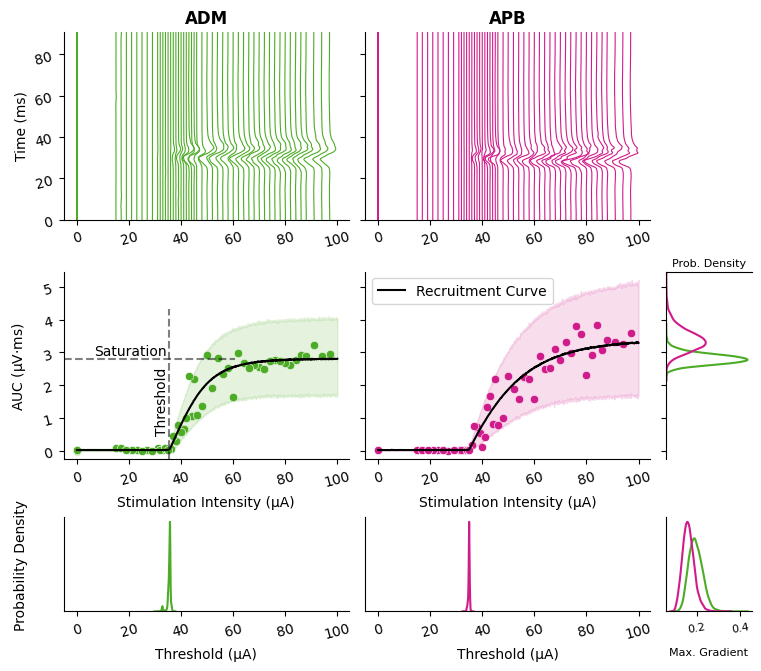

In [8]:
scatter_alpha = 1

a_, b_ = model.mep_window
time = np.linspace(a_, b_, mat.shape[1])
colors = [(0.3020, 0.6745, 0.1490), (0.8157, 0.1098, 0.5451)]
const = [500] * 2

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.2 * nrows), squeeze=False, constrained_layout=True, height_ratios=[1, 1, .5], width_ratios=[1, 1, .3])

for muscle_ind in [0, 1]:
    ax = axes[0, muscle_ind]
    for k in range(mat.shape[0]):
        x = mat[k, :, muscle_ind] / const[muscle_ind]
        x += df[model.intensity].values[k]
        ax.plot(x, time * 1000, color=colors[muscle_ind], linewidth=.8, alpha=1)
    # ax.set_yticks(np.array([0, 0.005, 0.01]))
    ax.set_ylim(bottom=-0.001, top=(model.mep_size_window[1] + (model.mep_size_window[0] - (-0.001))) * 1000)

    ax = axes[1, muscle_ind]
    sns.lineplot(x=prediction_df[model.intensity], y=obs.mean(axis=0)[..., muscle_ind], ax=ax, color="black", alpha=1, label="Recruitment Curve")
    sns.scatterplot(x=df[model.intensity], y=df[model.response[muscle_ind]], color=colors[muscle_ind], alpha=1, ax=ax)
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hpdi[0, ..., muscle_ind],
        obs_hpdi[1, ..., muscle_ind],
        color=colors[muscle_ind],
        alpha=.15
    )
    if ax == axes[1, 0]:
        ax.axvline(x=a_map[0, 0, muscle_ind], color="black", alpha=.5, linestyle="--", ymax=.8)
        ax.text(a_map[0, 0, muscle_ind], obs_map.max(axis=0)[muscle_ind] - .25, "Threshold", rotation=90, va="top", ha="right")

    if ax == axes[1, 0]:
        ax.axhline(y=obs_map.max(axis=0)[muscle_ind], color="black", alpha=.5, linestyle="--", xmax=.6)
        ax.text(a_map[0, 0, muscle_ind] - 15, obs_map.max(axis=0)[muscle_ind], "Saturation", va="bottom", ha="center")

    ax = axes[2, muscle_ind]
    sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    # ins = ax.inset_axes([0.6,0.4,0.3,0.5])
    # sns.kdeplot(a[:, 0, 0, muscle_ind], ax=ins, color=colors[muscle_ind])
    # ins.set_xlabel("")
    # ins.set_ylabel("")
    # if muscle_ind == 0:
    #     ins.set_xticks([99, 102])
    #     ins.set_xlim(left=98, right=103)
    # if muscle_ind == 1:
    #     ins.set_xticks([27, 31])
    #     ins.set_xlim(left=26, right=32)
    # ins.tick_params(
    #     axis='both',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     left=False,      # ticks along the bottom edge are off
    #     bottom=True,      # ticks along the bottom edge are off
    #     right=False,         # ticks along the top edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=True,
    #     labelleft=False,
    #     labelright=False,
    #     labelsize=8,
    #     labelrotation=10
    # )

    ax = axes[1, 2]
    if muscle_ind == 0:
        sns.kdeplot(y=H[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])
    if muscle_ind == 1:
        sns.kdeplot(y=H[:, 0, 0, muscle_ind], ax=ax, color=colors[muscle_ind])

    ax = axes[2, 2]
    max_grad = fn_prime_out.max(axis=1)[..., muscle_ind]
    sns.kdeplot(max_grad, ax=ax, color=colors[muscle_ind])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        ax.set_xlabel("")
        ax.set_ylabel("")

subset = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    sides = ['right', 'top']
    for side in sides:
        ax.spines[side].set_visible(False)
    if j == 0:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=True,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 1:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
    if j == 2:
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=10,
            labelsize=8
        )

subset = [(2, 0), (2, 1), (2, 2)]
for i, j in subset:
    ax = axes[i, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
        labelleft=False,
    )

axes[0, 1].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])

axes[0, 1].sharex(axes[0, 0])
axes[1, 0].sharex(axes[0, 0])
axes[1, 1].sharex(axes[0, 0])

# axes[0, 0].set_xticks([0, 100, 200])
# axes[0, 0].set_yticks([0, 5, 10])
# axes[1, 0].set_yticks([0, 500, 1000])

axes[1, 1].legend(loc="upper left")
if axes[1, 0].get_legend():
    axes[1, 0].get_legend().set_visible(False)

axis_label_size = 10
axes[0, 0].set_ylabel("Time (ms)", size=axis_label_size)
axes[1, 0].set_ylabel("AUC (µV$\cdot$ms)", size=axis_label_size)

axes[1, 0].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)
axes[1, 1].set_xlabel("Stimulation Intensity (µA)", size=axis_label_size)

axes[2, 0].sharex(axes[0, 0])
axes[2, 1].sharex(axes[0, 0])
# axes[2, 1].sharey(axes[2, 0])
# axes[2, 0].set_ylim(bottom=-0.018)
axes[2, 0].set_ylabel("Probability Density")

axes[2, 0].set_xlabel("Threshold (µA)", size=axis_label_size)
axes[2, 1].set_xlabel("Threshold (µA)", size=axis_label_size)

# axes[2, 2].sharey(axes[2, 0])
# axes[2, 2].set_xlim(left=8, right=32)
# axes[2, 2].set_xticks([10, 20, 30])
axes[2, 2].set_xlabel("Max. Gradient", size=8)

ax = axes[0, 2]
sides = ['left', 'top', 'bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False
)

ax = axes[1, 2]
sides = ['bottom', 'right']
for side in sides:
    ax.spines[side].set_visible(False)
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    bottom=False,
    right=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    labelright=False,
    labeltop=False,
    labelrotation=10,
    labelsize=8
)
ax.set_xlabel("Prob. Density", size=8)
axes[1, 2].sharey(axes[1, 0])
axes[1, 2].xaxis.set_label_position('top')
# axes[1, 2].set_xlim(left=-0.0006)
# axes[1, 2].set_xticks([0, 0.015/2, 0.015])

axes[0, 0].set_title("ADM", fontweight="bold")
axes[0, 1].set_title("APB", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(model.build_dir, "a-meps.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "a-meps.png")
fig.savefig(dest, dpi=600)


In [17]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/fig_1/tms/a-meps.png'